<a href="https://www.kaggle.com/tnqzh123/my-musical-preference-final-spbpu-ws-2022-ml?scriptVersionId=88619069" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## !!! STATEMENT !!!

**This notebook is done by Steven Qiu (QIU Zaihong) from Shanghai Maritime University, as the final project for course _Machine Learning: Theory and Application_ by Peter the Great St. Petersburg Polytechnic University Winter School 2022.** It's open sourced under MIT license, you may check it on GitHub: https://github.com/tnqzh123/mymusicalpreferences .

The competiton score(accuracy of prediction) may be effected by the randomness of `train_test_split` and model fitting. All predictions are generated by the same code(okay maybe some variable and syntax has a little difference but actually all codes are doing the same thing), whether score is high or low.

**HAPPY 2022 LUNAR NEW YEAR !!!**

## Preparation

### Import Often-used Libraries

In [1]:
!pip install deep-forest

     |████████████████████████████████| 2.4 MB 3.1 MB/s            
     |████████████████████████████████| 14.8 MB 35.8 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
thinc 8.0.13 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.0.1 which is incompatible.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but 

_Don't worry about this ERROR, it doesn't contain packages we need to use in this notebook._

In [2]:
import pandas as pd
import numpy as np
import missingno

### Read Data

In [3]:
PATH = '../input/mymusicalprefrences/'
dataAll = pd.concat([pd.read_csv(PATH + 'train.csv'), pd.read_csv(PATH + 'test.csv')]).reset_index(drop = True)
dataAll.rename(columns = {'Vocal ': 'Vocal'}, inplace = True) # Remove the space

Check the shape of data.

In [4]:
dataAll.shape

(965, 18)

Make a list of features.

In [5]:
dataAll.columns

Index(['Id', 'Category', 'Artists', 'Track', 'Version', 'Duration',
       'Artists_Genres', 'Album', 'Release_year', 'Album_type', 'Labels',
       'Key', 'BPM', 'Vocal', 'Country', 'Energy', 'Dancebility', 'Happiness'],
      dtype='object')

In [6]:
features = {
    'cat': {
        'single': ['Track', 'Version', 'Album', 'Album_type', 'Key'],
        'multiple': ['Artists', 'Artists_Genres', 'Vocal', 'Labels', 'Country']
    },
    'num': ['Category', 'Duration', 'Release_year', 'BPM', 'Energy', 'Dancebility', 'Happiness']
}

## Data Preprocessing

### Fill Missing Value

<AxesSubplot:>

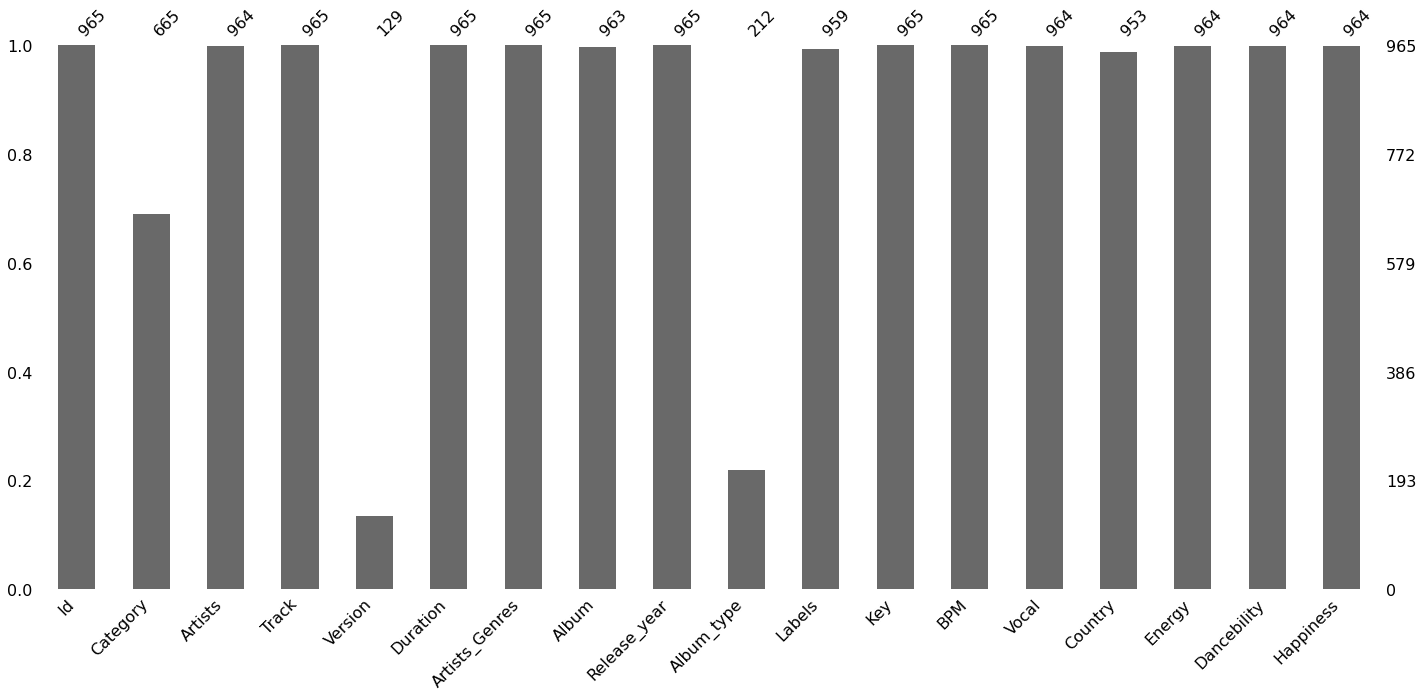

In [7]:
missingno.bar(dataAll)

One row of training data is mostly filled with `NaN`. It's useless so I droped it.

In [8]:
dataAll[dataAll['Artists'].isna()]

,Id,Category,Artists,Track,Version,Duration,Artists_Genres,Album,Release_year,Album_type,Labels,Key,BPM,Vocal,Country,Energy,Dancebility,Happiness
661,661,0.0,NaN,"La Traviata - Opera in three acts, Act I: Libi...",Remaster,182000,|classical|vocal,Verdi: La Traviata,2017,NaN,EMI Records Ltd. Digital remastering,B♭ Minor,69,N,NaN,NaN,NaN,NaN


In [9]:
dataAll = dataAll.drop(661).reset_index(drop = True)

Fill some missing data with true value irl. These data are collected by searching in Google.

- Album

In [10]:
dataAll[dataAll['Album'].isna()]

,Id,Category,Artists,Track,Version,Duration,Artists_Genres,Album,Release_year,Album_type,Labels,Key,BPM,Vocal,Country,Energy,Dancebility,Happiness
250,250,0.0,Martin Solveig|Dragonette,Hello,Radio Edit,191620,dance|electronics|pop|pop|dance|electronics,NaN,2010,single,NaN,E♭ Major,128,M,CA|SWE,98.0,67.0,45.0
501,501,1.0,The Notorious B.I.G.,Big Poppa,Radio Edit,252920,foreignrap|rnb|dance,NaN,1995,NaN,NaN,A Minor,84,M,USA,57.0,78.0,77.0


In [11]:
dataAll.at[250, 'Album'] = 'Hello'
dataAll.at[501, 'Album'] = 'Ready to Die'

- Labels

In [12]:
dataAll[dataAll['Labels'].isna()]

,Id,Category,Artists,Track,Version,Duration,Artists_Genres,Album,Release_year,Album_type,Labels,Key,BPM,Vocal,Country,Energy,Dancebility,Happiness
85,85,0.0,Reamonn,Tonight,NaN,215130,rock|pop,Lifestyle2 - Acoustic Vol 2,2006,compilation,NaN,E Minor,145,M,DE,72.0,53.0,22.0
195,195,1.0,Mattafix,Big City Life,NaN,240890,foreignrap|pop,Signs Of A Struggle,2008,NaN,NaN,D Major,174,M,GB,62.0,69.0,73.0
250,250,0.0,Martin Solveig|Dragonette,Hello,Radio Edit,191620,dance|electronics|pop|pop|dance|electronics,Hello,2010,single,NaN,E♭ Major,128,M,CA|SWE,98.0,67.0,45.0
501,501,1.0,The Notorious B.I.G.,Big Poppa,Radio Edit,252920,foreignrap|rnb|dance,Ready to Die,1995,NaN,NaN,A Minor,84,M,USA,57.0,78.0,77.0
508,508,0.0,The Rasmus,In The Shadows,Radio Edit,257920,alternative,Best of 2001-2009,2009,NaN,NaN,D Major,106,M,FIN,80.0,60.0,75.0
769,770,NaN,Gorillaz|Jamie Hewlett|De La Soul,Feel Good Inc.,Single Edit,224620,indie|foreignrap|dance|relax,Essential Bands,2005,compilation,NaN,F# Major,139,M,GB,70.0,82.0,77.0


In [13]:
dataAll.at[85, 'Labels'] = 'Universe International'
dataAll.at[195, 'Labels'] = 'Virgin'
dataAll.at[250, 'Labels'] = 'Mercury'
dataAll.at[501, 'Labels'] = 'Bad Boy'
dataAll.at[508, 'Labels'] = 'Playground Music'
dataAll.at[769, 'Labels'] = 'Virgin'

- Vocal

In [14]:
dataAll[dataAll['Vocal'].isna()]

,Id,Category,Artists,Track,Version,Duration,Artists_Genres,Album,Release_year,Album_type,Labels,Key,BPM,Vocal,Country,Energy,Dancebility,Happiness
736,737,NaN,Flux Pavilion,I Can't Stop,NaN,305780,electronics|dance|dubstep,Big Beat Dance Hits: Vol 1,2015,compilation,Big Beat,C Minor,140,NaN,GB,60.0,52.0,31.0


In [15]:
dataAll.at[736, 'Vocal'] = 'M'

- Country

Filling missing value in this column with `NA` because I don't really understand what is this and cannot found it by Google.

`NA` in this column means "Not Applicable", not North America or Namibia.

In [16]:
dataAll['Country'].fillna('NA', inplace = True)

- Version & Album_type

Filling missing value in these two columns with `N/A` because not all music are applicable to these two attribute.

In [17]:
dataAll['Version'].fillna('N/A', inplace = True)
dataAll['Album_type'].fillna('N/A', inplace = True)

<AxesSubplot:>

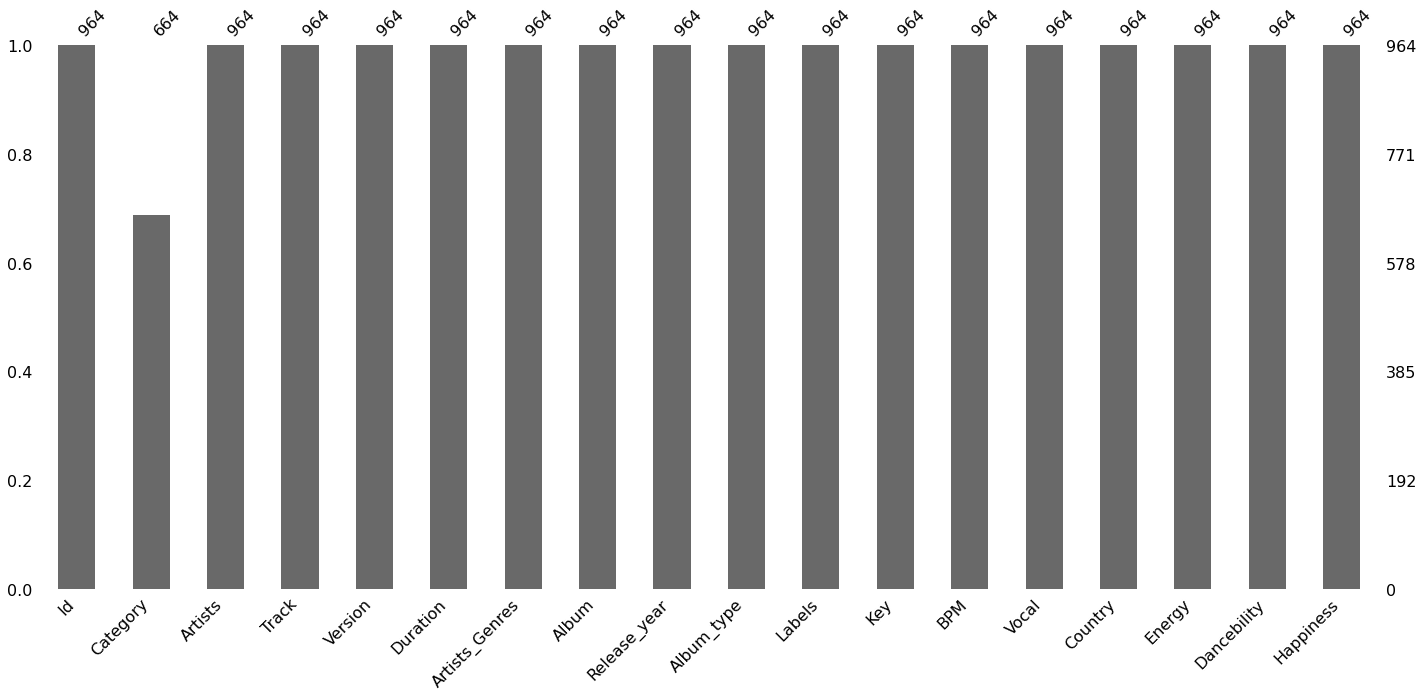

In [18]:
missingno.bar(dataAll)

Great! There are no missing value now, except "Category" column because missing value in this column means we need to predict it.

### Rename Value

`X♭` is thus enharmonic to `(X-1)#`, so I rename `X♭` value to `(X-1)#` for lower complexity and better accuracy.

In [19]:
dataAll['isMajor'], dataAll['Key'] = [item[1] for item in dataAll['Key'].str.split()], [item[0] for item in dataAll['Key'].str.split()]
dataAll['Key'].replace({"D♭": "C#", "E♭": "D#", "G♭": "F#", "A♭": "G#","B♭":"A#"}, inplace = True)
features['cat']['single'].append('isMajor')

## Feature Engineering

### Functions Defination

These funtions are copied from sample solution, I changed it only a little.

In [20]:
from sklearn.manifold import TSNE

def split_to_onehot(df, col):
    """
    This method converts features separated by '|' into one-hot vectors.
    Additionally it drops unnecessary values, which present only in 
    test set / train set or have only one value.
    """
    # Getting all unique ganres values.
    unique = []
    for i in df.index:
        unique.extend(df.loc[i,col].split("|"))
    if "" in unique:
        unique.remove("")
    unique = list(set(unique))

    # Putting values into binary form 
    onehot = df.loc[:,["Category"]]
    onehot = onehot.fillna('none').replace({0:"dislike",1:"like"})
    onehot[unique] = np.zeros((len(unique)), dtype = np.int8)
    for i in df.index:
        g = set(df.loc[i,col].split("|"))
        for j in g:
            if j!="":
                onehot.loc[i,j] = 1

    # Dropping unnecessary values            
    _a = onehot.groupby("Category").sum()
    only_one = list(_a.sum()[_a.sum()==1].index)
    only_train = list(_a.loc["none"][_a.loc["none"]==0].index)
    only_test = list(_a.loc[["like",'dislike']].sum()[_a.loc[["like",'dislike']].sum()==0].index)
    _a = set(only_one + only_train + only_test)
    onehot = onehot.drop(_a, axis=1)
    return onehot.drop(columns = 'Category')

def onehot_to_tsne2(df, title):
    """
    This method converts one-hot representation into two tsne values.
    Such operation is needed to shrink the dimentionality of the dataset
    """
    onehot = df #.drop("Category",axis=1)
    embedded = TSNE(n_components=2, init="pca").fit_transform(onehot)
    embedded = pd.DataFrame(embedded,columns=[f"{title}_tsne1",f"{title}_tsne2"])
    return embedded

### Encoding

Do label encoding and scaling for "Duration" and "Release_year".

In [21]:
for i in dataAll.index:
    dataAll.at[i, 'Duration'] /= 60000 # Milliseconds to minutes, isn't it a kind of scaling? XD
    if(dataAll.at[i, 'Release_year'] < 1980):
        dataAll.at[i, 'Release_year'] = 0 # Label encoding
        continue
    dataAll.at[i, 'Release_year'] -= dataAll.at[i, 'Release_year'] % 10 # Years to decades
    dataAll.at[i, 'Release_year'] = (dataAll.at[i, 'Release_year'] - 1970) / 10 # Label encoding

Label encoding features which only contains single value in the cell by with `LabelEncoder`.

In [22]:
from sklearn.preprocessing import LabelEncoder

for key in features['cat']['single']:
    if key == 'Track':
        continue # Why I skip "Track"? Please refer to "Build Model" section.
    dataAll[key] = LabelEncoder().fit_transform(dataAll[key])

One-Hot encoding features which contains multiple value in the cell with `split_to_onehot`, then reduce the dimensionality with `onehot_to_tsne2`. (Actually it's not really a One-Hot Encode, just kind similar to it.)

In [23]:
for key in features['cat']['multiple']:
    onehot = split_to_onehot(dataAll, key)
    tsne2 = onehot_to_tsne2(onehot, key)
    dataAll = pd.concat([dataAll.drop(columns = key), tsne2], axis = 1)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


_Please ignore these warnings...I don't know why they doesn't appear in example solution and it seems to be a lot of work to fix it, so just left them here because "Programmers do not care warnings but errors" XDDD_

## Build Models

### Split Data Using In Training And Predicting

In [24]:
from sklearn.model_selection import train_test_split

dataBuilding = dataAll.drop(columns = ['Id', 'Track']).copy() # I droped "Track" feature because people won't like or dislike a song just by it's name
trainData, predictData = dataBuilding.loc[: 663], dataBuilding.loc[664:].drop(columns = ['Category']).copy()
dataTraining, dataTesting = dict(), dict()
dataTraining['feature'], dataTesting['feature'], dataTraining['result'], dataTesting['result'] = train_test_split(trainData.drop(columns = 'Category'), trainData['Category'], test_size = 0.2, shuffle = True)

Combining different models to a `VotingClassifier`, then train it.

In [25]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from deepforest import CascadeForestClassifier
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier([
    ('SVM', SVC()),
    ('RandomForest', RandomForestClassifier()),
    ('KNeighbors', KNeighborsClassifier()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder = False, eval_metric = ['logloss', 'auc', 'error'])),
    ('CatBoost', CatBoostClassifier(verbose = False)),
    ('DeepForest', CascadeForestClassifier(verbose = False))
])

voting.fit(dataTraining['feature'].to_numpy(), dataTraining['result'].to_numpy())

VotingClassifier(estimators=[('SVM', SVC()),
                             ('RandomForest', RandomForestClassifier()),
                             ('KNeighbors', KNeighborsClassifier()),
                             ('DecisionTree', DecisionTreeClassifier()),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=['logloss', 'auc',
                                                         'error'],
                                            g...
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                  

## Make Prediction

Finally, we can make the prediction, then export the answer to `submission.csv`.

**CAULTION**: some classifier may return float numbers as result, but Kaggle doesn't accept float numbers as prediction - it will judge float prediction as wrong answer - at lease in this competition. We need to convert float numbers to integer numbers. (I got 5 "Score: 0" just because this stupid problem!!!)

In [26]:
answer = pd.read_csv(PATH + 'sample_submition.csv')
answer['Category'] = voting.predict(predictData.to_numpy())
answer['Category'] = answer['Category'].astype(int)
answer.to_csv('submission.csv', index = False)